# NOAA: Detecting SST Anomalies Using A Unsupervised Learning Approach

***Introduction***

The purpose of this notebook serves to further build on our learnings from the noaa_evaluation EDA and attempt to train supervised model training where we will cross validate the results against our random forest regressor using a time-series structure in order to further strengthen the conclusion and results that we have managed to create. We aim to do this by making a comparative analysis between the timestamps of SST anomalies and the prediction results from our Random Forest Regressor that will be tested on the NOAA dataset.

Please keep in mind that the noaa_evaluation notebook can be looked at as a mandatory pre-requisite to this part of our findings as we build on the fundamental learnings and results.

***Contents***
For the contents of this notebook, we can break it down into three main sections Feature Engineering, Unsupervised Training, Cross-Validation of Models

- Feature Engineering: This section builds the neccessary feature variables that are used throughout the unsupervised training

- Unsupervised Training: This section covers the selection and training of our unsupervised model where we will attempt to accurately detect SST anomalies

- Cross-Validation of Models: This section builds on the previous sections model where we shall cross validate it's results with our Random Forest Regressor and test it's predictive accuracy to further prove our models strength


In [120]:
# Standard Libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys

sys.path.append('..')

# Custom Tools
from load import load_noaa_station_data
from utils import create_noaa_date_column, create_noaa_seasonal_column, convert_to_numeric
from scipy.stats import zscore

# Wrangling tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Regression Models
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

Firstly, let's read the dataset that we pulled and combined for multiple regions and stations in our Multi-Set Analysis (Section 2). This has already be ran through the mini data transformation pipeline that we wrote, so the Season and Date columns are already appended together with the appropriate data type castings:

In [121]:
combined_regional_df = pd.read_csv('../../data/noaa/pulled_data/coral_reef_data_combined.csv')

print('Number of rows:', len(combined_regional_df))
print(combined_regional_df.describe())
print(combined_regional_df.dtypes)

Number of rows: 177043
                YYYY             MM             DD       SST_MIN  \
count  177043.000000  177043.000000  177043.000000  177043.00000   
mean     2004.700525       6.487887      15.722932      26.78480   
std        11.662090       3.452751       8.797549       1.96167   
min      1985.000000       1.000000       1.000000      17.09000   
25%      1995.000000       3.000000       8.000000      25.65000   
50%      2005.000000       6.000000      16.000000      27.23000   
75%      2015.000000       9.000000      23.000000      28.24000   
max      2025.000000      12.000000      31.000000      31.44000   

             SST_MAX    SST@90th_HS   SSTA@90th_HS      90th_HS>0  \
count  177043.000000  177043.000000  177043.000000  177043.000000   
mean       28.117110      27.775844       0.533198       0.187283   
std         1.601725       1.627570       0.623586       0.373325   
min        21.400000      21.240000      -2.350300       0.000000   
25%        27.11000

## Section 1: EDA Revision & Extended Analysis

### Sub Sections:

- Sub-section 1.1: EDA Revision

- Sub-section 1.2: Deeper Time-Series Analysis

### Sub-section 1.1: EDA Revision

***EDA Recap***

Just to give a short recap to what we discovered in our previous findings, if we recall to the Single-Set Anlaysis and particularly our discoveries within the sub-section 1.3 of our distdistributionribtuion analysis, you will see that we found a normal distribution when analysing the SSTA@90th_HS>0. 

We logically built on that finding by mapping the seasonal fluctuations via grouping the columns by seasons then re-plotting the distributions from each season in the subsequent sub-section 1.4. It was from this analysis that we were able to conclude that the SST anomaly distribution was in fact ***not*** influenced by seasonal changes. 

Another key insight and derived data that we were able to retrieve from this section can be seen in sub-section 1.5 where we made a time-series analysis and pinpointed the exact time delays measured in days for the maximum correlation that these results had with when mapped to the BAA severity levels. We will also be leveraging these results and building the majority of the next sub-section from this finding.

***Building on Those Concepts***

It is within this section that we can truly leverage the findings from sub-section 1.4 and 1.5 by building on the concept and trying to engineer ourselves a model that will help detect SST anomalies before they even happen. 

The target of this build is to not only further strengthen the conclusions drawn for our prior analysis, but to also build an extended model that will allow individuals and scientists to predict SST anomalies before they occur, ultimately creating an early warning system for potential SST anomalies with hopes to be married 
together with our RFR prediction model from previous notebook.

Before we dive into the feature engineering of our unsupervised learning model, we need to particularly revisit a single part of our EDA analysis from the first notebook. This is will be the time-series analysis from subsections 1.5 and 2.5. We must do this as it is the pinnacle for the model.

### Sub-section 1.2: Deep Time-Series Analysis

Within this revisit, we will be taking a deeper dive into the time-series lags for the correlations that the values have with not only the BAA severity levels, but with each other. 

As we will be focusing particularly onto the SST anomalies within this section, we would like to do a deepened time-series analysis with a particular aim to detect any patterens within the SST Anomalies


***Rolling Window Analysis***

We can get started by doing a rolling window analysis. Please find the reference here: [MATLAB Rolling Window](https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html)

As said in the MATLAB's example, we can need to define the rolling window. Since we are working over a fairly long time-period, I would like to follow their advice of: "In general, you can use a short rolling window size for data collected in short intervals, and a larger size for data collected in longer intervals". Therefore lets go with the window size 30 days for month segments to begin with. First lets sort the rows by date to ensure we have the correct timeline. I also want to index the Date column for faster queries and ease:

In [122]:
combined_regional_df = combined_regional_df.sort_values('Date')
combined_regional_df.set_index('Date', inplace=True)

print(combined_regional_df.head())

            YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-01  1985   1   1    28.82    29.25        29.03        0.7797   
1985-01-01  1985   1   1    28.30    29.03        28.69        0.5165   
1985-01-01  1985   1   1    28.22    28.84        28.73        0.0039   
1985-01-01  1985   1   1    24.13    24.70        24.32       -0.3071   
1985-01-01  1985   1   1    25.76    27.85        27.54        0.2771   

            90th_HS>0  DHW_from_90th_HS>1  BAA_7day_max  \
Date                                                      
1985-01-01       0.56                 0.0             0   
1985-01-01       0.13                 0.0             0   
1985-01-01       0.00                 0.0             0   
1985-01-01       0.00                 0.0             0   
1985-01-01       0.00                 0.0             0   

                          Station              Region  Latitude  Longitude

Data is in ascending order now, let's set the window size to 30 days as we determined above:

In [123]:
window_size = 30

Calculate the mean and the standard deviation to begin with using the 30 day segment window size:

In [124]:
combined_regional_df['SSTA_rolling_mean'] = combined_regional_df['SSTA@90th_HS'].rolling(window=window_size).mean()
combined_regional_df['SSTA_rolling_std'] = combined_regional_df['SSTA@90th_HS'].rolling(window=window_size).std()

print(combined_regional_df[['SSTA@90th_HS', 'SSTA_rolling_mean', 'SSTA_rolling_std']].head(40)) # I check for 40 because the first 29 rows will likely be NaN because of the window size

            SSTA@90th_HS  SSTA_rolling_mean  SSTA_rolling_std
Date                                                         
1985-01-01        0.7797                NaN               NaN
1985-01-01        0.5165                NaN               NaN
1985-01-01        0.0039                NaN               NaN
1985-01-01       -0.3071                NaN               NaN
1985-01-01        0.2771                NaN               NaN
1985-01-01       -0.5255                NaN               NaN
1985-01-01       -0.3077                NaN               NaN
1985-01-01        0.0552                NaN               NaN
1985-01-01       -0.1884                NaN               NaN
1985-01-01        0.2116                NaN               NaN
1985-01-01        0.6171                NaN               NaN
1985-01-01        0.1297                NaN               NaN
1985-01-02        0.0352                NaN               NaN
1985-01-02       -0.4571                NaN               NaN
1985-01-

As expected, we have NaN for the first 29 rows, but the other rows have properly calculated values. This is expected because the calculation requires the full window length!

We can quickly drop those NaN values:

In [125]:
length_before_drop = len(combined_regional_df)
combined_regional_df = combined_regional_df.dropna(subset=['SSTA_rolling_mean', 'SSTA_rolling_std'])
length_after_drop = len(combined_regional_df)

print(f'Dropped {length_before_drop - length_after_drop} rows for the NaN')
print(combined_regional_df[['SSTA@90th_HS', 'SSTA_rolling_mean', 'SSTA_rolling_std']].head()) 

Dropped 29 rows for the NaN
            SSTA@90th_HS  SSTA_rolling_mean  SSTA_rolling_std
Date                                                         
1985-01-03        0.3132           0.092740          0.405322
1985-01-03       -0.2174           0.059503          0.387539
1985-01-03       -0.5723           0.023210          0.394192
1985-01-03        0.1529           0.028177          0.394878
1985-01-03       -0.3471           0.026843          0.396115


As recalled from the sub-section 1.4 in the noaa_evaluation under the single-set analysis, we already have the knowledge that the distribution for the SSTA was in fact a normal distribution. This means that ofcourse, we can use the +/- 2 standard deviations rule. This basically tells us that 95% of all the data points are within +/- 2 standard deviations from the mean:

In [126]:
upper_threshold = combined_regional_df['SSTA_rolling_mean'] + 2 * combined_regional_df['SSTA_rolling_std']
lower_threshold = combined_regional_df['SSTA_rolling_mean'] - 2 * combined_regional_df['SSTA_rolling_std']

***Plot***

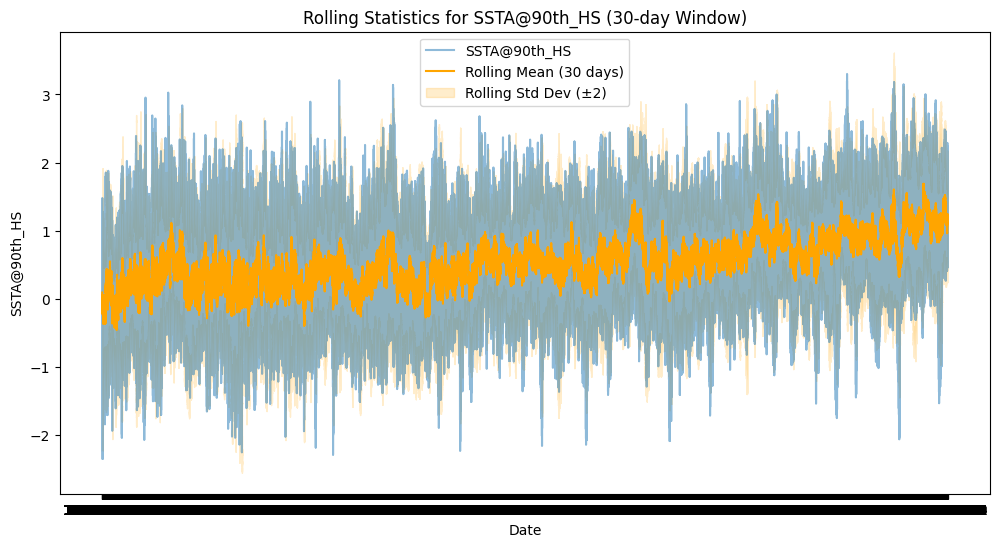

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(combined_regional_df.index, combined_regional_df['SSTA@90th_HS'], label='SSTA@90th_HS', alpha=0.5)
plt.plot(combined_regional_df.index, combined_regional_df['SSTA_rolling_mean'], label='Rolling Mean (30 days)', color='orange')
plt.fill_between(combined_regional_df.index, lower_threshold, upper_threshold, color='orange', alpha=0.2, label='Rolling Std Dev (±2)')
plt.title('Rolling Statistics for SSTA@90th_HS (30-day Window)')
plt.xlabel('Date')
plt.ylabel('SSTA@90th_HS')
plt.legend()
plt.show()

***Interpretation & Takeways***

- **Blue (SSTA@90th_HS)**: This blue line shows us the original time-series data for the SST anomalies, i.e. the raw values for the SSTA@90th_HS. This seems to show relatively stable over the past years from 1985 - 2025

- **Orange (Rolling Mean(30 days))**: This orange line represents the mean value from the rolling window. We find this useful fo seeing the true trend over the past years. Here we can interestingly see that the mean seems to very interestingly increase over the time period in a positive direction which we can deduce as likely seeing more anomaly spikes in within the recent years.

- **Yellow (Rolling Std Dev(+/-2))**: Remember this is the SD of +/- 2 from the mean so it is showing us the anomalies that is captured in 95% of raw SSTA values. This basically gives us the visiuals on the volatility of the SST anomalies over time. Here we also seem to see an upward trend in the recent years.

- **Anomalies (Implicitly Derived)**: This can be looked at as the values from the raw SST anomalies which are outside of the standard deviation range, i.e. the yellow lines.We know that these values are basically the extreme SST anomalies that are significantly spread from the expected range, thus what we are interested in.

Lets make another plot to isolate the anomalies and solely focus into those. Ofcourse we can just capture the anomlies in the upper and lower range from the +/= 2 sd that we discussed:

In [128]:
combined_regional_df['SSTA_anomaly'] = ((combined_regional_df['SSTA@90th_HS'] > upper_threshold) | (combined_regional_df['SSTA@90th_HS'] < lower_threshold)).astype(int)

print(combined_regional_df[combined_regional_df['SSTA_anomaly'] == 1])

            YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-05  1985   1   5    25.60    26.34        26.26       -1.0797   
1985-01-05  1985   1   5    28.71    30.67        29.64        1.3177   
1985-01-05  1985   1   5    28.54    30.00        29.85        1.4794   
1985-01-07  1985   1   7    21.37    22.69        22.45       -1.5342   
1985-01-08  1985   1   8    20.84    22.04        21.75       -2.0787   
...          ...  ..  ..      ...      ...          ...           ...   
2025-05-20  2025   5  20    29.51    30.65        30.31        2.0352   
2025-05-21  2025   5  21    29.55    30.97        30.41        2.1403   
2025-05-22  2025   5  22    29.66    30.96        30.50        2.1732   
2025-05-23  2025   5  23    29.55    31.21        30.82        2.2235   
2025-05-24  2025   5  24    29.23    31.10        30.60        2.2155   

            90th_HS>0  DHW_from_90th_HS>1  BAA_7da

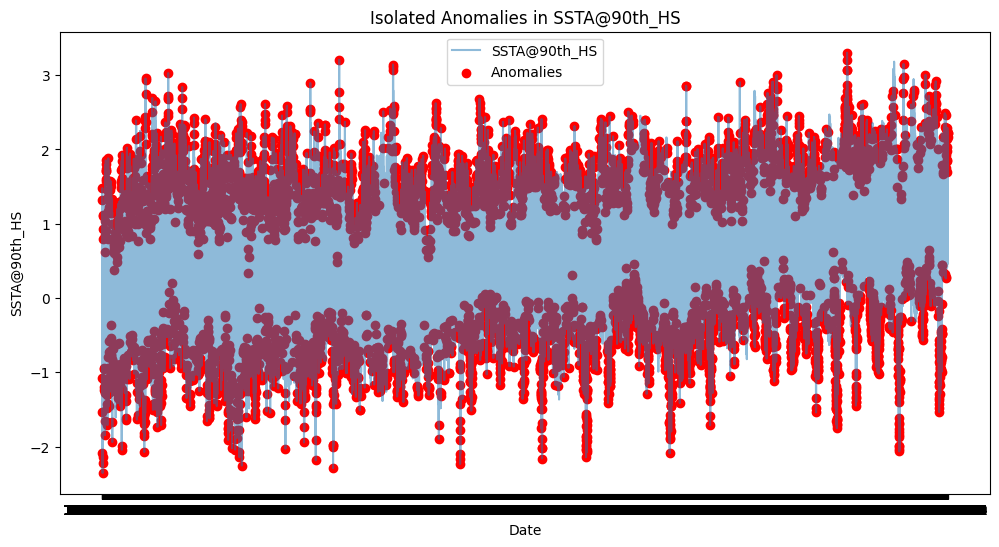

In [129]:
plt.figure(figsize=(12, 6))
plt.plot(combined_regional_df.index, combined_regional_df['SSTA@90th_HS'], label='SSTA@90th_HS', alpha=0.5)
plt.scatter(combined_regional_df.index[combined_regional_df['SSTA_anomaly'] == 1],
            combined_regional_df['SSTA@90th_HS'][combined_regional_df['SSTA_anomaly'] == 1],
            color='red', label='Anomalies')
plt.title('Isolated Anomalies in SSTA@90th_HS')
plt.xlabel('Date')
plt.ylabel('SSTA@90th_HS')
plt.legend()
plt.show()

***Interpretation***

- **Red (Anomalies)**: The red dots represent the anomalies. There are several key takeaways from here that we will get into.

- **Light Blue Shade (Raw SSTA values)**: This simply just represents the raw data values as we saw from earlier. This is just makes it easier for us to see and sor t of intuitively makes sense to map on top of tha anomalies


***Takeaways***

There are a couple of key insights that I would like to point out here: clustering patterns, and a upward positive trend in recent years.

- **Anomaly Clusters**: As can be visually seen from the graph, we seem to see certain clusters of anomalies, this indicates to us that the there could actually be patterns and trends for anomalies during certain periods. This is crucial knowledge for our model

- **Upward Trend**: We can also deduce from the graph that there seems to also be an upward trend in the anomalies throughout the time-period where we see that the temperature is actually indeed increasing the most recent years.

- **Volatile Anomalies**: Lastly, if we look closely, we can see that there are some anomaly volatility over time. To put it more clear, we can see that some years show much high anomaly spikes compared to others. This indicates to us that there likely was some years that imposed higher risks on bleaching severity levels compared to others.

***Conclusion***

What we conclude from this is that the SST anomalies seem to appear in cluster patterns, this would conclude that we might be able to detect future anomalies once we understand how these patterns occur. 

Not only that, but in the time line trend, we seem to see a gradual increase towards upper percentile SST anomalies. This indicates to use that there might be hidden driving factors to increased water temperature also hinting to further evidence of gradual climate change and SST temperature increase over a long period of time.

We also witnessed certain years having much more clusters of SST anomalies compared to others which made us questions what other factors could be making this effect. I would just like to take one more plot to visualise the concept that we just mention here:

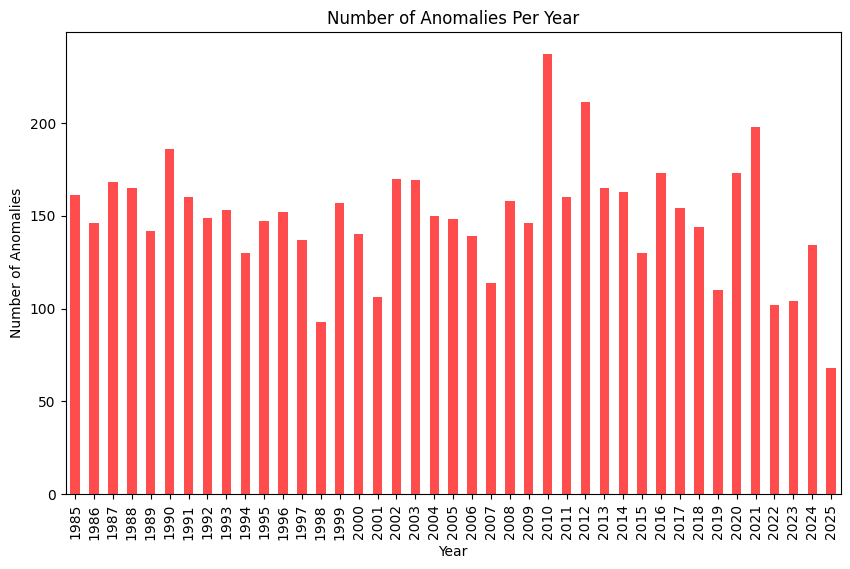

In [130]:
combined_regional_df.index = pd.to_datetime(combined_regional_df.index) 

combined_regional_df['Year'] = combined_regional_df.index.year
anomalies_per_year = combined_regional_df[combined_regional_df['SSTA_anomaly'] == 1].groupby('Year').size()

plt.figure(figsize=(10, 6))
anomalies_per_year.plot(kind='bar', color='red', alpha=0.7)
plt.title('Number of Anomalies Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Anomalies')
plt.show()

## Section 2: Feature Engineering

### Sub Sections:

- Sub-section 2.1: Defining & Implementing Features

### Sub-Section 2.1: Defining & Implementing Features

The chosen features that we will be working with and engineering from are as follows:

- **Rolling Mean and Standard Deviation**: As covered in our previous section and actually already defined in ur dataframe, we will be using the rolling mean and SD from the rolling analysis that we did.

- **Year**: We are adding a Year column to the dataframe in order to do some grouping by year, because we witnessed that some years had more anomaly clusters and it made sense to do a year by year analysis.

- **Time Lags from EDA 1**: Exactly what we concluded and included in our first NOAA EDA from the higher level time-series analysis, we will want to be including the same time lag features here again as that will come in handy for anomaly detection

In [131]:
print(combined_regional_df.columns)

Index(['YYYY', 'MM', 'DD', 'SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS',
       '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max', 'Station', 'Region',
       'Latitude', 'Longitude', 'Season', 'SSTA_rolling_mean',
       'SSTA_rolling_std', 'SSTA_anomaly', 'Year'],
      dtype='object')


As we can confirm from the print above, we already have the necessary feature columns for the rolling mean, rolling SD, and year. The only feature variables that we are missing are the time lags. Since we have already done this in notebook 1, let us just quickly copy and past them back to here. 

We can bring all of them over except for the DHW and the 90th_HS threshold time lags. We don't want these because we are just trying to detect the anomaly patterns and it might introduce the risk of overfitting as they are measuring threshold values rather than SST values:

In [132]:
combined_regional_df['SST_MIN_lag_back_4'] = combined_regional_df['SST_MIN'].shift(-4)
combined_regional_df['SST_MAX_lag_back_4'] = combined_regional_df['SST_MAX'].shift(-4)
combined_regional_df['SST@90th_HS_lag_back_4'] = combined_regional_df['SST@90th_HS'].shift(-4)
combined_regional_df['SSTA@90th_HS_lag_back_3'] = combined_regional_df['SSTA@90th_HS'].shift(-3)

Do one last NaN drop to just to be sure we have a clean set after introducing new time lags:

In [133]:
combined_regional_df = combined_regional_df.dropna()

print(combined_regional_df[['SST_MIN_lag_back_4', 'SST_MAX_lag_back_4', 'SST@90th_HS_lag_back_4', 'SSTA@90th_HS_lag_back_3']].head())

            SST_MIN_lag_back_4  SST_MAX_lag_back_4  SST@90th_HS_lag_back_4  \
Date                                                                         
1985-01-03               24.06               24.77                   24.63   
1985-01-03               26.07               26.74                   26.57   
1985-01-03               28.80               29.27                   29.03   
1985-01-03               25.69               26.60                   26.52   
1985-01-03               23.48               24.20                   24.06   

            SSTA@90th_HS_lag_back_3  
Date                                 
1985-01-03                   0.1529  
1985-01-03                  -0.3471  
1985-01-03                  -0.6484  
1985-01-03                   0.7219  
1985-01-03                  -0.8406  


Lastly, we will need to just setup a scaled features variable. Ofcourse as we in the unsupervised learning realm, we will not need to be doing any data splits. We just need to define the features that we are working with as already known from above and scale them along with the other values. 

Let us just do a quick re-check now of all values, decide what to drop, then scale the rest

In [134]:
print('Columns in the dataset:', combined_regional_df.head())

Columns in the dataset:             YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-03  1985   1   3    25.88    27.98        27.78        0.3132   
1985-01-03  1985   1   3    26.85    27.08        26.98       -0.2174   
1985-01-03  1985   1   3    26.09    26.67        26.63       -0.5723   
1985-01-03  1985   1   3    28.24    29.01        28.92        0.1529   
1985-01-03  1985   1   3    24.06    24.77        24.63       -0.3471   

            90th_HS>0  DHW_from_90th_HS>1  BAA_7day_max  ... Longitude  \
Date                                                     ...             
1985-01-03        0.0                 0.0             0  ...  -163.625   
1985-01-03        0.0                 0.0             0  ...    81.575   
1985-01-03        0.0                 0.0             0  ...   -78.700   
1985-01-03        0.0                 0.0             0  ...  -170.475   
1985-01-03        0.

In [135]:
columns_to_drop = ['Latitude', 'Longitude', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max', 'Season', 'Station', 'Region']
combined_regional_df = combined_regional_df.drop(columns=columns_to_drop)

print(combined_regional_df.columns)

Index(['YYYY', 'MM', 'DD', 'SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS',
       'SSTA_rolling_mean', 'SSTA_rolling_std', 'SSTA_anomaly', 'Year',
       'SST_MIN_lag_back_4', 'SST_MAX_lag_back_4', 'SST@90th_HS_lag_back_4',
       'SSTA@90th_HS_lag_back_3'],
      dtype='object')


In [136]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_regional_df)

## Section 3: Unsupervised Model Training

At last, we have gotten to the step where we can begin to train these models and have an attempt at some unsupervised learnings in order to capture anomaly detections

### Sub Sections:

- Sub-section 3.1: Model Selections & Reasoning 

- Sub-section 3.2: Model Testing and Comparison

- Subsection 3.3: Cross-Validation of models

- Subsection 3.4

### Sub-Section 3.1: Model Selections & Reasoning



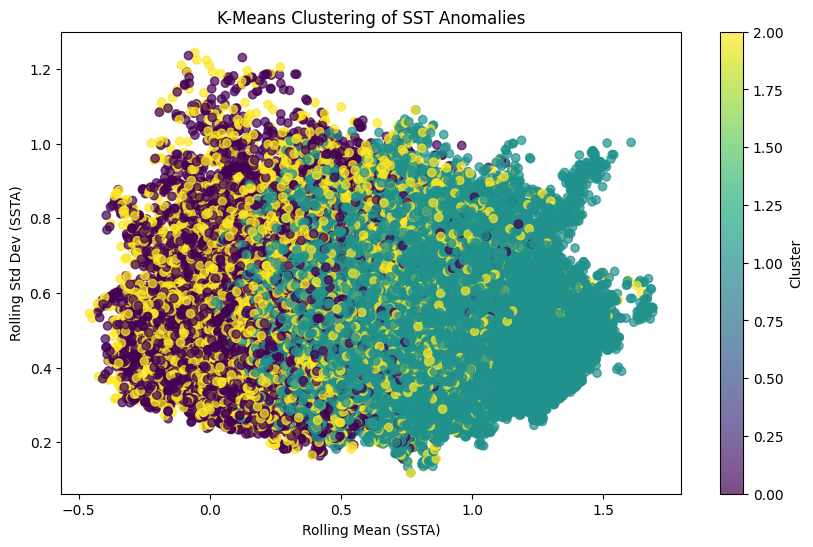

In [137]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42) 
combined_regional_df['Cluster_KMeans'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(combined_regional_df['SSTA_rolling_mean'], combined_regional_df['SSTA_rolling_std'], 
            c=combined_regional_df['Cluster_KMeans'], cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering of SST Anomalies')
plt.xlabel('Rolling Mean (SSTA)')
plt.ylabel('Rolling Std Dev (SSTA)')
plt.colorbar(label='Cluster')
plt.show()

            YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-03  1985   1   3    25.88    27.98        27.78        0.3132   
1985-01-03  1985   1   3    26.85    27.08        26.98       -0.2174   
1985-01-03  1985   1   3    26.09    26.67        26.63       -0.5723   
1985-01-03  1985   1   3    28.24    29.01        28.92        0.1529   
1985-01-03  1985   1   3    24.06    24.77        24.63       -0.3471   
...          ...  ..  ..      ...      ...          ...           ...   
2025-05-24  2025   5  24    29.91    30.88        30.76        0.9487   
2025-05-24  2025   5  24    28.42    29.96        29.44        1.3532   
2025-05-24  2025   5  24    28.33    29.81        29.09        1.3110   
2025-05-24  2025   5  24    25.11    27.49        27.08        1.3084   
2025-05-24  2025   5  24    28.94    30.33        30.27        1.1774   

            SSTA_rolling_mean  SSTA_rolling_std  S

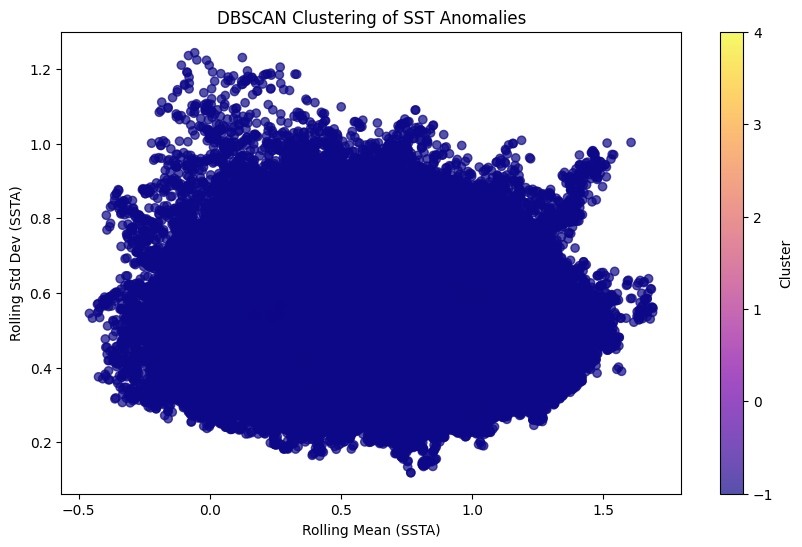

In [138]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5) 
combined_regional_df['Cluster_DBSCAN'] = dbscan.fit_predict(scaled_features)

print(combined_regional_df[combined_regional_df['Cluster_DBSCAN'] == -1])

plt.figure(figsize=(10, 6))
plt.scatter(combined_regional_df['SSTA_rolling_mean'], combined_regional_df['SSTA_rolling_std'], 
            c=combined_regional_df['Cluster_DBSCAN'], cmap='plasma', alpha=0.7)
plt.title('DBSCAN Clustering of SST Anomalies')
plt.xlabel('Rolling Mean (SSTA)')
plt.ylabel('Rolling Std Dev (SSTA)')
plt.colorbar(label='Cluster')
plt.show()

In [139]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01, random_state=42)  
combined_regional_df['Anomaly_IF'] = iso_forest.fit_predict(scaled_features)

print(combined_regional_df[combined_regional_df['Anomaly_IF'] == -1])

            YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-03  1985   1   3    24.06    24.77        24.63       -0.3471   
1985-01-05  1985   1   5    25.60    26.34        26.26       -1.0797   
1985-01-05  1985   1   5    21.99    23.11        22.75       -1.0803   
1985-01-06  1985   1   6    21.68    23.02        22.86       -0.9003   
1985-01-07  1985   1   7    21.37    22.69        22.45       -1.5342   
...          ...  ..  ..      ...      ...          ...           ...   
2025-02-13  2025   2  13    21.01    24.11        23.44       -0.0745   
2025-02-16  2025   2  16    21.81    24.86        24.08        0.4475   
2025-02-20  2025   2  20    22.01    24.78        24.21        0.4475   
2025-03-04  2025   3   4    23.15    25.07        24.45        0.3518   
2025-04-03  2025   4   3    29.01    29.94        29.75        2.2984   

            SSTA_rolling_mean  SSTA_rolling_std  S